In [ ]:
%cd './drive/MyDrive/Cardiac Project/Registration_phase'

/content/drive/MyDrive/Cardiac Project/Registration_phase


# Imports

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.autograd import Variable
from torchvision import transforms

import random
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split


import skimage.io as io
from skimage.transform import resize
#import multiprocessing as mp #


#import gc #
#from matplotlib.lines import Line2D #
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
use_gpu = torch.cuda.is_available()

# Dataset Creation

In [ ]:
path = './phase_2_voxel_morph/voxelMorph/'

In [ ]:
def read_dataset(path):
    cine_dataset = []
    lge_dataset = []
    for filename in tqdm(glob.iglob(path + "**/*.png" , recursive = True)):
        class_type = filename.split('/')[2]
        image_name = filename.split('/')[3]
        image = cv2.imread(filename ,  cv2.IMREAD_GRAYSCALE)
        image = transforms.ToTensor()(image)
        if class_type == 'cine_images':
            cine_dataset.append((image , image_name))
        if class_type == 'lge_images':
            lge_dataset.append((image , image_name))

    cine_dataset.sort(key = lambda x: x[1]) 
    lge_dataset.sort(key = lambda x: x[1]) 
 
    dataset = []
    for i in range(len(cine_dataset)):
        cine_image = cine_dataset[i][0]
        lge_image = lge_dataset[i][0]
        dataset.append((cine_image , lge_image))

    return dataset

In [ ]:
dataset = read_dataset(path)

598it [03:30,  2.84it/s]


In [ ]:
train_dataset , test_dataset = train_test_split(dataset, test_size=0.33, random_state=42)

ValueError: ignored

In [ ]:
train_loader = data.DataLoader(train_dataset ,
                               batch_size = 20,
                               shuffle = True,
                               num_workers =  6,
                               worker_init_fn =  np.random.seed(42))  
test_loader = data.DataLoader(test_dataset ,
                               batch_size = 20,
                               shuffle = True,
                               num_workers =  6,
                               worker_init_fn =  np.random.seed(42))                      

# Model Definition

In [ ]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        """
        This function creates one contracting block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This function creates one expansive block
        """
        block = torch.nn.Sequential(
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ReLU(),
            torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1),
            torch.nn.BatchNorm2d(mid_channel),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        return block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This returns final block
        """
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.ReLU()
                )
        return block

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=16)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(16, 32)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(32, 32)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode4 = self.contracting_block(32, 32)
        self.conv_maxpool4 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        mid_channel = 32
        self.bottleneck = torch.nn.Sequential(
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel, out_channels=mid_channel , padding=1),
                                torch.nn.BatchNorm2d(mid_channel * 2),
                                torch.nn.ReLU(),
                                torch.nn.Conv2d(kernel_size=3, in_channels=mid_channel, out_channels=mid_channel, padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                                torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=mid_channel, kernel_size=3, stride=2, padding=1, output_padding=1),
                                torch.nn.BatchNorm2d(mid_channel),
                                torch.nn.ReLU(),
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(32, 32, 32)
        self.conv_decode2 = self.expansive_block(32, 16, 16)
        self.final_layer = self.final_block(16, 16, out_channel)

    def crop_and_concat(self, upsampled, bypass, crop=False):
        """
        This layer crop the layer from contraction block and concat it with expansive block vector
        """
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1)
        final_layer = self.final_layer(decode_block1)
        return  final_layer


In [ ]:
class SpatialTransformation(nn.Module):
    def __init__(self, use_gpu=False):
        self.use_gpu = use_gpu
        super(SpatialTransformation, self).__init__()

    def meshgrid(self, height, width):
        x_t = torch.matmul(torch.ones([height, 1]), torch.transpose(torch.unsqueeze(torch.linspace(0.0, width -1.0, width), 1), 1, 0))
        y_t = torch.matmul(torch.unsqueeze(torch.linspace(0.0, height - 1.0, height), 1), torch.ones([1, width]))

        x_t = x_t.expand([height, width])
        y_t = y_t.expand([height, width])
        if self.use_gpu==True:
            x_t = x_t.cuda()
            y_t = y_t.cuda()

        return x_t, y_t

    def repeat(self, x, n_repeats):
        rep = torch.transpose(torch.unsqueeze(torch.ones(n_repeats), 1), 1, 0)
        rep = rep.long()
        x = torch.matmul(torch.reshape(x, (-1, 1)), rep)
        if self.use_gpu:
            x = x.cuda()
        return torch.squeeze(torch.reshape(x, (-1, 1)))


    def interpolate(self, im, x, y):
        im = im.permute(0,2,3,1)
        im = F.pad(im, (0,0,1,1,1,1,0,0))
        
        batch_size, height, width, channels = im.shape
        batch_size, out_height, out_width = x.shape

        x = x.reshape(1, -1)
        y = y.reshape(1, -1)

        x = x + 1
        y = y + 1

        max_x = width - 1
        max_y = height - 1

        x0 = torch.floor(x).long()
        x1 = x0 + 1
        y0 = torch.floor(y).long()
        y1 = y0 + 1

        x0 = torch.clamp(x0, 0, max_x)
        x1 = torch.clamp(x1, 0, max_x)
        y0 = torch.clamp(y0, 0, max_y)
        y1 = torch.clamp(y1, 0, max_y)

        dim2 = width
        dim1 = width*height
        base = self.repeat(torch.arange(0, batch_size)*dim1, out_height*out_width)

        base_y0 = base + y0*dim2
        base_y1 = base + y1*dim2

        idx_a = base_y0 + x0
        idx_b = base_y1 + x0
        idx_c = base_y0 + x1
        idx_d = base_y1 + x1

        # use indices to lookup pixels in the flat image and restore
        # channels dim
        im_flat = torch.reshape(im, [-1, channels])
        im_flat = im_flat.float()
        dim, _ = idx_a.transpose(1,0).shape
        Ia = torch.gather(im_flat, 0, idx_a.transpose(1,0).expand(dim, channels))
        Ib = torch.gather(im_flat, 0, idx_b.transpose(1,0).expand(dim, channels))
        Ic = torch.gather(im_flat, 0, idx_c.transpose(1,0).expand(dim, channels))
        Id = torch.gather(im_flat, 0, idx_d.transpose(1,0).expand(dim, channels))

        # and finally calculate interpolated values
        x1_f = x1.float()
        y1_f = y1.float()

        dx = x1_f - x
        dy = y1_f - y

        wa = (dx * dy).transpose(1,0)
        wb = (dx * (1-dy)).transpose(1,0)
        wc = ((1-dx) * dy).transpose(1,0)
        wd = ((1-dx) * (1-dy)).transpose(1,0)

        output = torch.sum(torch.squeeze(torch.stack([wa*Ia, wb*Ib, wc*Ic, wd*Id], dim=1)), 1)
        output = torch.reshape(output, [-1, out_height, out_width, channels])
        return output.permute(0,3,1,2)

    def forward(self, moving_image, deformation_matrix):
        dx = deformation_matrix[:, :, :, 0]
        dy = deformation_matrix[:, :, :, 1]

        batch_size, height, width = dx.shape

        x_mesh, y_mesh = self.meshgrid(height, width)

        x_mesh = x_mesh.expand([batch_size, height, width])
        y_mesh = y_mesh.expand([batch_size, height, width])
        x_new = dx + x_mesh
        y_new = dy + y_mesh

        return self.interpolate(moving_image, x_new, y_new)


NameError: ignored

In [ ]:
class VoxelMorph2d(nn.Module):
    def __init__(self, in_channels, use_gpu=False):
        super(VoxelMorph2d, self).__init__()
        self.unet = UNet(in_channels, 2)
        self.spatial_transform = SpatialTransformation(use_gpu)
        if use_gpu:
            self.unet = self.unet.cuda()
            self.spatial_transform = self.spatial_transform.cuda()

    def forward(self, moving_image, fixed_image):
        
        x = torch.cat([moving_image, fixed_image], dim=1)
        deformation_matrix = self.unet(x).permute(0,2,3,1)
        registered_image = self.spatial_transform(moving_image, deformation_matrix)
        return registered_image

NameError: ignored

# SetUp Model

In [ ]:
def cross_correlation_loss(I, J, n):

    batch_size, channels, xdim, ydim = I.shape
    I2 = torch.mul(I, I)
    J2 = torch.mul(J, J)
    IJ = torch.mul(I, J)
    sum_filter = torch.ones((1, channels, n, n))
    if use_gpu:
        sum_filter = sum_filter.cuda()
    I_sum = torch.conv2d(I, sum_filter, padding=1, stride=(1,1))
    J_sum = torch.conv2d(J, sum_filter,  padding=1 ,stride=(1,1))
    I2_sum = torch.conv2d(I2, sum_filter, padding=1, stride=(1,1))
    J2_sum = torch.conv2d(J2, sum_filter, padding=1, stride=(1,1))
    IJ_sum = torch.conv2d(IJ, sum_filter, padding=1, stride=(1,1))
    win_size = n**2
    u_I = I_sum / win_size
    u_J = J_sum / win_size
    cross = IJ_sum - u_J*I_sum - u_I*J_sum + u_I*u_J*win_size
    I_var = I2_sum - 2 * u_I * I_sum + u_I*u_I*win_size
    J_var = J2_sum - 2 * u_J * J_sum + u_J*u_J*win_size
    cc = cross*cross / (I_var*J_var + np.finfo(float).eps)
    return torch.mean(cc)

def smooothing_loss(y_pred):
    y_pred = y_pred.permute(0,2,3,1)
    dy = torch.abs(y_pred[:, 1:, :, :] - y_pred[:, :-1, :, :])
    dx = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])

    dx = torch.mul(dx, dx)
    dy = torch.mul(dy, dy)
    d = torch.mean(dx) + torch.mean(dy)
    return d/2.0

def vox_morph_loss(y, ytrue, n=9, lamda=0.1):
    cc = cross_correlation_loss(y, ytrue, n)
    sm = smooothing_loss(y)
    #print("CC Loss", cc, "Gradient Loss", sm)
    loss = -1.0 * cc + lamda * sm
    return loss

def dice_score(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    top = 2 *  torch.sum(pred * target, [1, 2, 3])
    union = torch.sum(pred + target, [1, 2, 3])
    eps = torch.ones_like(union) * 1e-5
    bottom = torch.max(union, eps)
    dice = torch.mean(top / bottom)
    #print("Dice score", dice)
    return dice

In [ ]:
def train(model , train_loader ,epochs):
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_dice = 0
        for fixed_batch , moving_batch in train_loader:
            optimizer.zero_grad()
            fixed_batch = fixed_batch.to(device)
            moving_batch = moving_batch.to(device)
            registered_images = model(moving_batch , fixed_batch)
            train_loss = vox_morph_loss(registered_images, fixed_batch)
            train_loss.backward()
            optimizer.step()
            epoch_loss += train_loss.item()
            batch_dice = dice_score(registered_images ,fixed_batch )
            epoch_dice += batch_dice.item()
        print(epoch , epoch_loss/len(train_dataset) ,epoch_dice/len(train_dataset) )

In [ ]:
model = VoxelMorph2d(in_channels=2, use_gpu = use_gpu)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train(model , train_loader , epochs = 50)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0 -0.012777435980486066 0.020422497324729234
1 -0.014925840865360217 0.020830665579002896
2 -0.01647887085930685 0.021107163322105837
3 -0.017644351955210226 0.021234553014294485
4 -0.018555367093407705 0.021319402570135138
5 -0.019317945402659728 0.021387140737490706
6 -0.01997152975436007 0.02140941613175896
7 -0.02059077714266402 0.021442247240730884
8 -0.4139240417587623 0.02131952897886212
9 -0.015509858392597584 0.021072217252817046
10 -0.014766938063535797 0.02098884006564537
11 -0.014542208293850502 0.020949373419365185
12 -0.014539631732394186 0.020972900176316166
13 -0.014565029003646937 0.020985987748992577
14 -0.014584120069996695 0.02097113530957297
15 -0.014616144674547603 0.020985593956507995
16 -0.014637262968534834 0.020974479029687604
17 -0.014681920576631353 0.020985005611784003
18 -0.014745753132895138 0.02098363604438439
19 -0.014739273136921143 0.020988325222154682
20 -0.01471001160948464 0.020971292357766225
21 -0.014750007665559147 0.02098163945621319
22 -0.0147

In [ ]:
def test(model , test_loader):
    with torch.no_grad():
        all_loss = 0
        for fixed_batch , moving_batch in test_loader:
            fixed_batch = fixed_batch.to(device)
            moving_batch = moving_batch.to(device)
            registered_images = model(moving_batch , fixed_batch)
            test_loss = vox_morph_loss(registered_images, fixed_batch)
            all_loss += test_loss.item()
        print(all_loss/len(test_dataset)) 
        return fixed_batch, moving_batch , registered_images      

In [ ]:
fixed_batch, moving_batch , registered_images    = test(model , test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-0.01678585024042563


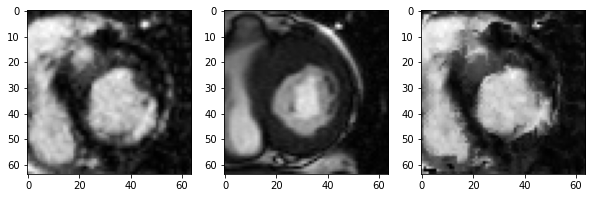

In [ ]:
sample = 1
fig , (ax1 , ax2 , ax3) = plt.subplots(1,3,figsize = (10,10))
ax1.imshow(moving_batch[sample].squeeze(0).cpu() , cmap = 'gray')
ax2.imshow(fixed_batch[sample].squeeze(0).cpu() , cmap = 'gray')
ax3.imshow(registered_images[sample].squeeze(0).cpu() , cmap = 'gray')